# Alveoli and acinar size
This document is used to plot the acinar volumes and stereological counts for the alveolar manuscript.

In [1]:
# Assess coding style, based on https://stackoverflow.com/a/47204361/323100

# %load_ext pycodestyle_magic
# and then put '%%pycodestyle' in the cells

# Or do it like so from the Terminal:
# jupyter nbconvert Load\ Datenblatt\ Stefan.ipynb --to script && flake8 *.py --ignore=W391

First, we set up the notebook.

In [2]:
#Load the data and set up notebook
import matplotlib.pyplot as plt
%matplotlib inline
import platform
import glob
import os
import pandas
import seaborn
import re
import timeit

In [3]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [4]:
the_current_git_hash = get_git_hash()
print('We are working with version %s of the analyis notebook'
      % the_current_git_hash)

We are working with version e8526dc of the analyis notebook


In [5]:
# Display defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['savefig.transparent'] = True  # Save figures with transparent background

In [6]:
# Make us an output folder (including the git hash, so we (potentially) have different versions of the images)
imgdir = os.path.join('img', the_current_git_hash)
os.makedirs(imgdir, exist_ok=True)

Now we load the 'Count' data from Eveline.

In [7]:
# Different locations if running either on Linux or Windows
if 'debian' in platform.dist():
    drive = os.path.join(os.sep, 'home', 'habi', 'nas_gruppe_schittny')
else:
    drive = os.path.join('\\\\nas.ana.unibe.ch\\', 'gruppe_schittny', 'Data')
# Load the data from this folder
RootPath = os.path.join(drive, 'doc', 'David')
print('We are loading all the data from %s' % RootPath)

We are loading all the data from /home/habi/nas_gruppe_schittny/doc/David


In [8]:
# Get a list of *all* excel files that Eveline exported from the STEPanizer
# Based on https://stackoverflow.com/a/14798263
StepanizerFiles = sorted(glob.glob(os.path.join(RootPath, 'Eveline', '**/*.xls'), recursive=True))

In [9]:
print('Eveline counted the alveoli in %s acini' % len(StepanizerFiles))

Eveline counted the alveoli in 285 acini


In [10]:
# Generate an empty dataframe where we save the counts
Counts = pandas.DataFrame()

In [11]:
# # Grab relevant data from filenames
# for f in StepanizerFiles:
#     print('Animal', os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3])
#     print('Day', os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2])
#     print('Acinus', os.path.basename(f).split('acinus')[1].split('_')[0])

In [12]:
Counts = pandas.DataFrame({'Location_Counts': StepanizerFiles})
Counts['Filename_Counts'] = [os.path.basename(f) for f in StepanizerFiles]
Counts['Animal'] = [os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3] for f in StepanizerFiles]
Counts['Day'] = [int(os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2]) for f in StepanizerFiles]
Counts['Acinus'] = [int(os.path.basename(f).split('acinus')[1].split('_')[0]) for f in StepanizerFiles]

In [13]:
# nr=16
# tmp=pandas.read_csv(StepanizerFiles[nr], nrows=13, delimiter='\t')
# # https://stackoverflow.com/a/31814158
# print('Eveline made', tmp['Total'][9], 'counts for', os.path.basename(StepanizerFiles[nr]))
# tmp

In [14]:
Counts['Counts'] = [int(pandas.read_csv(f, nrows=13, delimiter='\t')['Total'][10]) for f in StepanizerFiles]

In [15]:
# For D60, Eveline counted only half of the images, we thus double the 'counts'
Counts.loc[Counts.Day == 60, 'Counts'] = 2 * Counts['Counts']
# The 'number of images' (read below) stays the same, since Eveline just skipped the images in STEPanizer!

In [16]:
# STEPanizer pixel size
# Since we seem to have different tab-count in the files, we just read one single cell, explicitly...
Counts['Stepanizer pixel size'] = [float(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                                   skiprows=16, header=None, usecols=[0,1], nrows=1)[1][0])
                                   for f in StepanizerFiles]

In [17]:
# STEPanizer 'counting area' (equal to 'a(p)' in our case, since Eveline counted acinar entrance ring occurrence)
# Since we seem to have different tab-count in the files, we just read one single cell, explicitly...calc
Counts['Stepanizer counting area side length'] = [float(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                                                        skiprows=19, header=None,
                                                                        usecols=[0,1], nrows=1)[1][0])
                                                  for f in StepanizerFiles]

In [18]:
# Counting area in um²
Counts['Calculated counting area'] = [ca**2 for ca in Counts['Stepanizer counting area side length']]

In [19]:
# STEPanizer 'counting area' or 'a(p)'
# Since we seem to have different tab-count in the files, we just read one single cell, explicitly...calc
Counts['Stepanizer counting area'] = [float(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                                            skiprows=28, header=None, usecols=[0,1],
                                                            nrows=1)[1][0])
                                      for f in StepanizerFiles]

In [20]:
# # Difference in counting area of STEPanizer and calculated by ourselves
# # --> insignificant!
# seaborn.swarmplot(Counts['Stepanizer counting area'] - Counts['Calculated counting area'])
# plt.xlabel('Difference between calculation and STEPanizer data [um²]')
# plt.show()

# Laut Telefon mit Stefan (8.1.2018)
- Eveline zählte beide Richtungen -> Disector-Volumen verdoppeln (7.4 -> 14.8)
- Dies * Counting area -> Counting Volume
- Dies * Anzahl Bilder -> Total counting volume
- Counts pro totalem Volumen -> Alveolar fraction
- Alveolar fraction * Volumen aus MeVisLab -> Alveolen pro Acinus.


In [21]:
# Copied verbatim from ReadVolumeSurfaceAndAlveaolarNumber.py
DisectorThickness = 5  # slices
TOMCATPixelSize = 1.48   # um
ShrinkageFactor = 0.61   # Volume-Shrinkage-Factor = 61% with STD=5, calculated by Sébastien: Volume TOMCAT / Waterdisplacement

In [22]:
# Counting volume (in um³)
Counts['Counting volume'] = [DisectorThickness * TOMCATPixelSize * 2 * ca
                             for ca in Counts['Calculated counting area']]

In [23]:
# Read the counted images from the xls sheets (faster than counting the JPG files :) 
Counts['Number of images'] = [int(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                                  skiprows=12, header=None, usecols=[0,1, 2, 3],
                                                  nrows=1)[2][0][2:])  # Stefan writes '->NumImg' into the cell, so we read only everything from string position 3 on...
                              for f in StepanizerFiles]

In [25]:
# Calculate the total counting volume
Counts['Total counting volume'] = [cv * numimg for cv, numimg in zip(Counts['Counting volume'],
                                                                     Counts['Number of images'])]

In [25]:
# Counts per cm³
# To go from um³ to cm³ we multiply by 1e12: http://is.gd/wbZ81O
Counts['Alveolar fraction'] = [cnts / tcv * 1e12 for tcv, cnts in zip(Counts['Total counting volume'],
                                                                      Counts['Counts'])]

In [26]:
# Now let's load the volume to get the aveoli per acinus!

In [27]:
# Counts.head()

In [28]:
# Counts.tail()

In [29]:
print('We have %s acini which Eveline assessed with the STEPanizer' % len(Counts))

We have 285 acini which Eveline assessed with the STEPanizer


In [30]:
# Let's get a quick overview of the data
Counts.groupby(by=['Day', 'Animal'])['Counts'].describe()

count        mean         std    min     25%    50%     75%  \
Day Animal                                                                
4   04A      50.0   27.040000   23.687558    4.0   11.25   17.5   35.00   
    04B      23.0   65.043478   43.849410   15.0   34.50   53.0   80.00   
    04C      51.0   60.509804   45.424387   10.0   29.50   52.0   77.00   
10  10A      27.0   77.851852   56.305283   18.0   28.50   69.0  122.00   
    10B      14.0   84.571429   65.752115   23.0   37.50   52.0  135.25   
    10C      17.0  108.764706  125.449955   15.0   46.00   73.0  105.00   
21  21B      14.0  208.142857  197.709133   35.0   72.00  160.5  237.00   
    21D      15.0  181.133333  109.368882   50.0   90.00  167.0  253.50   
    21E      11.0  323.090909  145.936599  108.0  218.00  298.0  434.50   
60  60B      24.0  701.750000  230.946116  322.0  506.50  728.0  849.00   
    60C      20.0  207.600000  120.227153   60.0  136.00  172.0  254.00   
    60D      10.0  727.400000  198.946224  444.0  598.50  737.0  780.00   
    60E       9.0  791.555556  268.917790  272.0  736.00  740.0  944.00   

               max  
Day Animal          
4   04A      111.0  
    04B      171.0  
    04C      249.0  
10  10A      245.0  
    10B      199.0  
    10C      505.0  
21  21B      781.0  
    21D      379.0  
    21E      572.0  
60  60B     1296.0  
    60C      540.0  
    60D     1182.0  
    60E     1204.0

In [31]:
# Set ourselves a palette, based on the individual unique sample names
# The dictionary palette setting is based on the comments in https://stackoverflow.com/q/36554075/323100
ourcolors=seaborn.color_palette('husl', len(pandas.unique(Counts.Animal)))
ourpalette = {animal:ourcolors[c] for c, animal in enumerate(pandas.unique(Counts.Animal))}

In [32]:
# Set indivdual measurement color (in dataframe)
Counts['Color'] = [None] * len(Counts)
for c,animal in enumerate(Counts.Animal):
    for d,i in enumerate(pandas.unique(Counts.Animal)):
        if animal == i:
            Counts.set_value(c, 'Color', ourcolors[d])

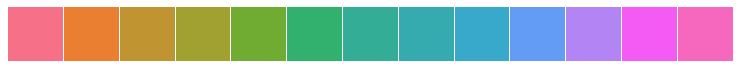

In [33]:
seaborn.palplot(ourcolors)

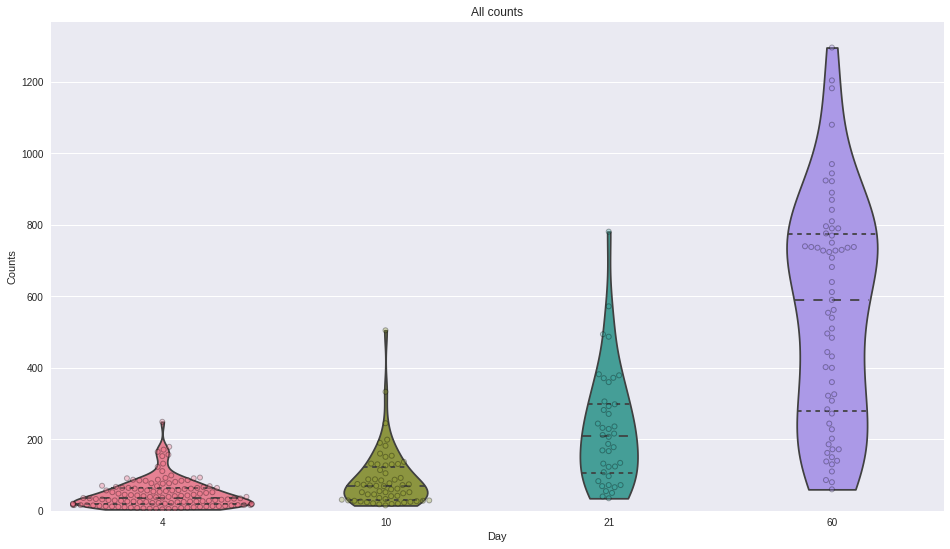

In [34]:
seaborn.violinplot(data=Counts, x='Day', y='Counts', cut=0, scale='count',
                   palette=seaborn.color_palette('husl', len(pandas.unique(Counts.Day))),
                   inner='quartiles')
seaborn.swarmplot(data=Counts, x='Day', y='Counts', split=False, linewidth=1,
                  palette=seaborn.color_palette('husl', len(pandas.unique(Counts.Day))),
                  edgecolor='k', alpha=0.309)
plt.title('All counts')
plt.ylim(ymin=0)
plt.savefig(os.path.join(imgdir, 'counts_global.png'), bbox_inches='tight')
plt.show()

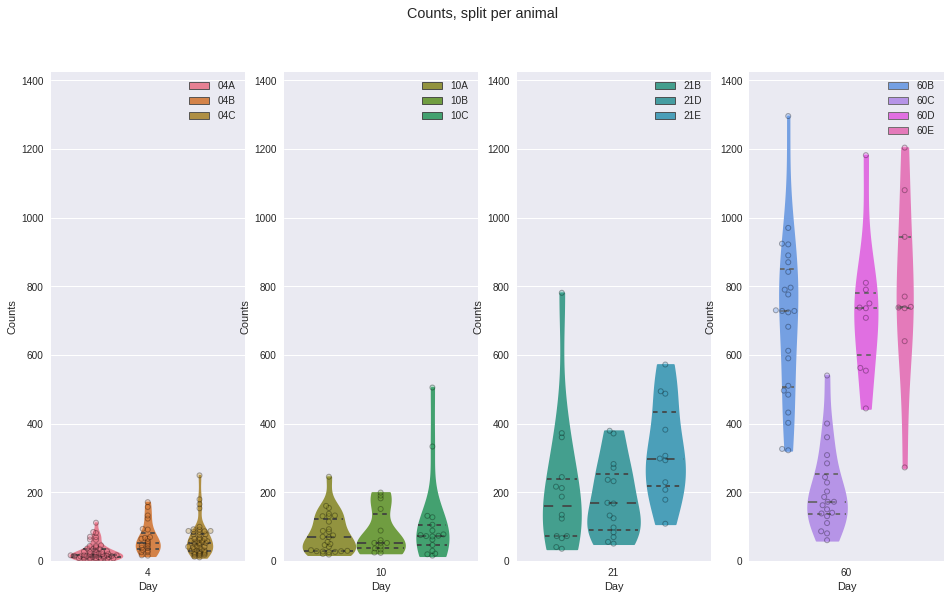

In [35]:
for c, d in enumerate(pandas.unique(Counts.Day)):
    plt.subplot(1, len(pandas.unique(Counts.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Counts.loc[Counts.Day == d], x='Day', y='Counts',
                               hue='Animal', palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.swarmplot(data=Counts.loc[Counts.Day == d], x='Day', y='Counts', hue='Animal',
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1*Counts.Counts.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2])
plt.suptitle('Counts, split per animal')
plt.savefig(os.path.join(imgdir, 'counts_day.png'), bbox_inches='tight')
plt.show()

Load the volume data directly from `anatera4`, where I originally exported the DICOM files from MeVisLab (and where the data still is).
After doing that, we save it to a dataframe on disk, since looking for all the DICOM files takes nearly an hour...

In [36]:
# Different locations if running either on Linux or Windows
if 'debian' in platform.dist():
    drive = '/run/user/1000/gvfs/smb-share:server=anatera4,share='
else:
    drive = '\\\\anatera4\\'
# Load the data from this folder
terastation = drive + os.path.join('share', 'SLS')
print('We are loading all the data from %s' % terastation)

We are loading all the data from /run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS


In [37]:
# Filename to save the data
OutputName = 'VolumesFromDisk.pkl'

In [38]:
# Get a list of *all* DICOM files that I exported aeons ago
# Based on https://stackoverflow.com/a/14798263
# This takes between 30 and 60 minutes!!!
# We thus only do it if we cannot read the dataframe with all the data that we save later on...
if os.path.exists(OutputName):
    print('We load the data from %s' % OutputName)
else:
    print('We scan %s for "R108*.dcm" files' % terastation)
    tic = timeit.default_timer()
    AcinarVolumeFiles = sorted(glob.glob(os.path.join(terastation, '**/R108*.dcm'), recursive=True))
    toc = timeit.default_timer()
    print('We found %s DICOM files in %s minutes' % (len(AcinarVolumeFiles),
                                                     round(float((toc - tic) / 60.), 1)))

We scan /run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS for "R108*.dcm" files


KeyboardInterrupt: 

In [ ]:
if os.path.exists(OutputName):
    # Load the data from disk
    VolumesFromDisk = pandas.read_pickle(OutputName)
else:
    # Generate an empty dataframe where we save the volumes
    VolumesFromDisk = pandas.DataFrame()

In [ ]:
# sorted(AcinarVolumeFiles_glob)[:5]

In [ ]:
# Save the filename into the dataframe
if not os.path.exists(OutputName):
    VolumesFromDisk = pandas.DataFrame({'Location_Volume': AcinarVolumeFiles})

In [ ]:
# # Grab relevant data from filenames
# for f in AcinarVolumeFiles:
#     print(os.path.basename(f))
#     print('Animal', os.path.basename(f).split('R108C')[1].split('mrg.')[0][:-2])
#     print('Day', os.path.basename(f).split('R108C')[1].split('mrg')[0][:2])
#     print('Acinus', os.path.basename(f).split('.acinus')[1].split('.volume')[0])
#     print('Volume', os.path.basename(f).split('.volume')[1].split('.pixelsize')[0])
#     print('Scantime', os.path.dirname(f).split('SLS')[1].split(os.sep)[1])
#     print(80*'-')

In [ ]:
# # Some names (see output of this cell) derive from the R108C$Day$$Animal$ scheme.
# # We catch them with the intricate .split() in the cells below...
# for i in VolumesFromDisk.File:
#     if len(i.split('mrg')[0][len('R108C'):-2]) >3:
#         tmp.append(i.split('mrg')[0][len('R108C'):-2])
# for i in pandas.unique(tmp):
#     print(i)

In [ ]:
if not os.path.exists(OutputName):
    VolumesFromDisk['Filename_Volume'] = [os.path.basename(f) for f in AcinarVolumeFiles]
    VolumesFromDisk['Animal'] = [os.path.basename(f).split('mrg')[0][len('R108C'):len('R108C')+3]
                                 for f in AcinarVolumeFiles]
    VolumesFromDisk['Beamtime'] = [os.path.dirname(f).split('SLS')[1].split(os.sep)[1]
                                   for f in AcinarVolumeFiles]
    VolumesFromDisk['Day'] = [int(os.path.basename(f).split('mrg')[0][len('R108C'):len('R108C')+2])
                              for f in AcinarVolumeFiles]
    VolumesFromDisk['Acinus'] = [int(os.path.basename(f).split('.acinus')[1].split('.volume')[0])
                                 for f in AcinarVolumeFiles]
    # According to the MeVisLab files, the volume is saved to the file name in 'ul'.
    # To get cm³ we simply multiply by 1000
    VolumesFromDisk['Volume'] = [1000 * float(os.path.basename(f).split('.volume')[1].split('.pixelsize')[0])
                                 for f in AcinarVolumeFiles]

In [ ]:
# Save the data and give some feedback.
if not os.path.exists(OutputName):
    VolumesFromDisk.to_pickle(OutputName)
print('We have %s acini where we got the volumes' % len(VolumesFromDisk))

In [ ]:
# List all the scan times (dates at TOMCAT)
# print(VolumesFromDisk['Scantime'].unique())

In [ ]:
VolumesFromDisk.groupby(by=['Day', 'Animal'])['Volume'].describe()

In [ ]:
# Update palette, since we might have more animals than what we had above in cell 19
ourcolors = seaborn.color_palette('husl', len(pandas.unique(VolumesFromDisk.Animal)))
ourpalette = {animal: ourcolors[c] for c, animal in enumerate(sorted(pandas.unique(VolumesFromDisk.Animal)))}

In [ ]:
# for c,d in enumerate(sorted(pandas.unique(VolumesFromDisk.Day))):
#     print(d)
#     print(pandas.unique(VolumesFromDisk.loc[VolumesFromDisk.Day == d]['Animal']))

In [ ]:
for c, d in enumerate(sorted(pandas.unique(VolumesFromDisk.Day))):
    plt.subplot(1, len(pandas.unique(VolumesFromDisk.Day)), c + 1)
    bxplt = seaborn.violinplot(data=VolumesFromDisk.loc[VolumesFromDisk.Day == d], x='Day', y='Volume',
                               hue='Animal',
                               # Because the animals are preferentially sorted on the beamtime name, we have
                               # to jump through the hoop below and sort the hues on the 'Animal' in addition
                               # to what we did for Evelines counts where all the data is in *one* folder
                               # Just comment the line to see the difference (a correct plot, but ugly sort :)
                               hue_order=sorted(pandas.unique(VolumesFromDisk.loc[VolumesFromDisk.Day == d]['Animal'])),
                               palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.swarmplot(data=VolumesFromDisk.loc[VolumesFromDisk.Day == d], x='Day', y='Volume',
                                hue='Animal',
                                hue_order=sorted(pandas.unique(VolumesFromDisk.loc[VolumesFromDisk.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1*VolumesFromDisk.Volume.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2])
plt.suptitle('Volumes, read from disk. Split per animal')
plt.savefig(os.path.join(imgdir, 'volumes_day.png'), bbox_inches='tight')
plt.show()

Now we 'just' have to concatenate the two dataframes :)

In [ ]:
# Merge the dataframes: http://pandas.pydata.org/pandas-docs/stable/merging.html
# This seems to discard all entries that are *not* found in both df's
print('\n\nTODO: confirm values by randomly sampling some file names and Count XLS sheets\n\n')
Merged = pandas.merge(Counts, VolumesFromDisk)#,
#                       on=['Animal', 'Acinus', 'Day'],
#                       how='inner',
#                       suffixes=('_from_counts', '_from_volume'))

In [ ]:
# Doublecheck merged file names (for 10 random items from dataframe)
# To make the checking a bit easier, we split the strings and only show the interesting bit
for i in range(5):
    number = numpy.random.randint(len(Merged))
    print('Beamtime:', Merged.iloc[number]['Scantime'])
    print('From Volume: Animal', Merged.iloc[number].Filename_Volume.split('mrg.')[0],
          '| Acinus',  Merged.iloc[number].Filename_Volume.split('acinus')[1].split('.volume')[0],
          '| Volume', Merged.iloc[number]['Volume'])
    print('From Counts: Animal', Merged.iloc[number].Filename_Counts.split('mrg-')[0][1:],
          '| Acinus',  Merged.iloc[number].Filename_Counts.split('acinus')[1].split('_201')[0],
          '| Counts', Merged.iloc[number]['Counts'])
    print('Alveolar fraction:', round(Merged.iloc[number]['Alveolar fraction'], 1) )
    print(40 * '-')

In [ ]:
Merged['CpV'] = Merged['Counts'] / Merged['Volume']

In [ ]:
for c, d in enumerate(sorted(pandas.unique(Merged.Day))):
    plt.subplot(1, len(pandas.unique(Merged.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Merged.loc[Merged.Day == d], x='Day', y='CpV',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                               palette=ourpalette, cut=0, inner='stick')
    swrmplt = seaborn.swarmplot(data=Merged.loc[Merged.Day == d], x='Day', y='CpV',
                                hue='Animal',
                                hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1*Merged.CpV.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2])
plt.suptitle('Counts per volume')
plt.savefig(os.path.join(imgdir, 'counts_per_volume_day.png'), bbox_inches='tight')
plt.show()

In [ ]:
# Plot mean +- STD
for c, d in enumerate(pandas.unique(Merged.Animal)):
    #     print(d)
    #     print(numpy.mean(Merged.loc[Merged.Animal == d]['Day']))
    #     print(numpy.mean(Merged.loc[Merged.Animal == d]['CpV']))
    #     print(numpy.std(Merged.loc[Merged.Animal == d]['CpV']))
    #     plt.scatter(numpy.mean(Merged.loc[Merged.Animal == d]['Day']), numpy.mean(Merged.loc[Merged.Animal == d]['CpV']))
    plt.errorbar(numpy.mean(Merged.loc[Merged.Animal == d]['Day']) + 0.25 * c % 5,
                 numpy.mean(Merged.loc[Merged.Animal == d]['CpV']),
                 yerr=numpy.std(Merged.loc[Merged.Animal == d]['CpV']),
                 fmt='o')
    plt.xlabel('Day')
    plt.ylabel('Counts per volume')
    plt.xlim([0, 65])
plt.savefig(os.path.join(imgdir, 'mean_counts.png'), bbox_inches='tight')
plt.show()

In [ ]:
Merged['Alveoli'] = Merged['Alveolar fraction'] * Merged['Volume']

In [ ]:
for c, d in enumerate(sorted(pandas.unique(Merged.Day))):
    plt.subplot(1, len(pandas.unique(Merged.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Merged.loc[Merged.Day == d], x='Day', y='Alveoli',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                               palette=ourpalette, cut=0, inner='stick')
    swrmplt = seaborn.swarmplot(data=Merged.loc[Merged.Day == d], x='Day', y='Alveoli',
                                hue='Animal',
                                hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * Merged.Alveoli.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2])
plt.suptitle('Number of alveoli')
plt.savefig(os.path.join(imgdir, 'number_of_alveoli.png'), bbox_inches='tight')
plt.show()

In [ ]:
# Plot mean +- STD
for c, d in enumerate(pandas.unique(Merged.Animal)):
    plt.errorbar(numpy.mean(Merged.loc[Merged.Animal == d]['Day']) + 0.25 * c % 5,
                 numpy.mean(Merged.loc[Merged.Animal == d]['Alveoli']),
                 yerr=numpy.std(Merged.loc[Merged.Animal == d]['Alveoli']),
                 fmt='o')
    plt.xlabel('Day')
    plt.ylabel('Alveoli')
    plt.xlim([0, 65])
plt.savefig(os.path.join(imgdir, 'mean_alveolis.png'), bbox_inches='tight')
plt.show()

----

The stuff below is from an old version of the [Jupyter notebook](http://jupyter.org), please disregard it for the moment...

----


Johannes also compiled a list of the volumes and saved them in an XLS file.
Let's load that, so that we can compare...

In [ ]:
# Read Volume data from Johannes' XLS-sheet
Volumes = pandas.read_excel(pandas.ExcelFile(os.path.join(RootPath, 'JCS', 'Acinarvol-JCS171122.xlsx'), sheet='Acinarvol'),
                        skiprows=19)


In [ ]:
# Drop the 'Unnamed' colums
Volumes.drop(list(Volumes.filter(regex='Unnamed')), axis=1, inplace=True)
# Drop the unnecessary columns
Volumes.drop('4.5', axis=1, inplace=True)
Volumes.drop('60.4', axis=1, inplace=True)

In [ ]:
# The data looks like that
Volumes.head()

In [ ]:
# Replace the column names to something meaningful
# Use some `regular expression` https://www.regular-expressions.info/anchors.html
Volumes.rename(columns=lambda x: re.sub('^4', '04', str(x)), inplace=True)
Volumes.rename(columns=lambda x: re.sub('\.1$', 'B', str(x)), inplace=True)
Volumes.rename(columns=lambda x: re.sub('\.2$', 'C', str(x)), inplace=True)
Volumes.rename(columns=lambda x: re.sub('\.3$', 'D', str(x)), inplace=True)
Volumes.rename(columns=lambda x: re.sub('\.4$', 'E', str(x)), inplace=True)
# https://stackoverflow.com/a/31697086/323100
Volumes.rename(columns=lambda x: re.sub(r'\b04\b', '04A', str(x)), inplace=True)
Volumes.rename(columns=lambda x: re.sub(r'\b10\b', '10A', str(x)), inplace=True)
Volumes.rename(columns=lambda x: re.sub(r'\b21\b', '21A', str(x)), inplace=True)
Volumes.rename(columns=lambda x: re.sub(r'\b36\b', '36A', str(x)), inplace=True)
Volumes.rename(columns=lambda x: re.sub(r'\b60\b', '60A', str(x)), inplace=True)

In [ ]:
Volumes.head()

In [ ]:
# Generate a color palette to distinguish between postnatal days
daycolor = [None] * len(Volumes.columns.values)
day = [None] * len(Volumes.columns.values)
for c,i in enumerate(Volumes.columns.values):
    if int(i[:-1])==4:
        day[c] = '04'
        daycolor[c] = seaborn.color_palette()[0]
    elif int(i[:-1])==10:
        day[c] = '10'
        daycolor[c] = seaborn.color_palette()[1]
    elif int(i[:-1])==21:
        day[c] = '21'
        daycolor[c] = seaborn.color_palette()[2]
    elif int(i[:-1])==36:
        day[c] = '36'
        daycolor[c] = seaborn.color_palette()[3]
    else:
        day[c] = '60'
        daycolor[c] = seaborn.color_palette()[4]

In [ ]:
# Plot the volume data
seaborn.violinplot(data=Volumes, cut=0, width=1, scale='count', palette=daycolor)
seaborn.swarmplot(data=Volumes, alpha=0.618, linewidth=1, palette=daycolor)
plt.title("Volumes from Johannes' XLS file")
plt.show()

In [ ]:
Volumes.describe()

# Bridges
Eveline also counted the [*bridges*](http://www.stereology.info/connectivity/) in the datasets.
Tiziana cleaned this data up and saved it to an Excel file (`acini merge.xlsx`).
We've made the file a bit more consistent (removing empty columns and rows, naming columns consistently, etc.) and work with this file (`acini merge_edit.xlsx`) below.

Below we load this file and calculate the number of acini according to [our paper for day 60](http://jap.physiology.org/content/115/9/1379).
The calculation for this paper was done in [MATLAB](https://www.mathworks.com/products/matlab.html)/[R](https://www.r-project.org/), nowadays I'm more handy with Python...

I was not able to find the original calculation script on the ana.unibe.ch network drives, but I seem to have saved a copy of the calculation and insertion to the [LaTeX](https://www.latex-project.org/) manuscript file in a *very* old [GitHub repository here](https://github.com/habi/AcinusPaperCode/blob/master/AcinarSize/ReadVolumeSurfaceAndAlveaolarNumber.py).

In [ ]:
DataFile = pandas.ExcelFile('acini merge_edit.xlsx')
print('The excel file contains the sheets:', end=' ')
for i in DataFile.sheet_names:
    print(i,end=', ')

In [ ]:
# Read the single sheets of the XLS file each into a dataframe
D04 = DataFile.parse(DataFile.sheet_names[0])
D10 = DataFile.parse(DataFile.sheet_names[1])
D21 = DataFile.parse(DataFile.sheet_names[2])
D60 = DataFile.parse(DataFile.sheet_names[3])

In [ ]:
# Rename 'Counts.' to 'Counts..0' (we use the Counts. counter later on)
D04.rename(columns={'Counts':'Counts.0'}, inplace=True)
D10.rename(columns={'Counts':'Counts.0'}, inplace=True)
D21.rename(columns={'Counts':'Counts.0'}, inplace=True)
D60.rename(columns={'Counts':'Counts.0'}, inplace=True)

In [ ]:
# For D60, Eveline counted only half of the images, we thus double the counts for this day.
print('Original D60')
print(D60.head())
for i in range(3):
    D60.iloc[:,2*i+1] =  D60.iloc[:,2*i+1] * 2
print('\nDouble the counts for D60')    
print(D60.head())    

We plot the data as [notched](https://en.wikipedia.org/wiki/Box_plot#Variations) boxplots.
The notches give a rough guide to the significance of difference of medians; if the notches of two boxes do not overlap, this offers evidence of a statistically significant difference between the medians.
On top of the boxplots we do a jittered scatterplot of the datapoints, to see the distribution of the data points.

In [ ]:
#Plot the 'counts' from Eveline
upper_limit=1350
plt.subplot(141)
seaborn.boxplot(data=D04.iloc[:,[1,3,5]], color=seaborn.color_palette()[0], notch=True)
seaborn.swarmplot(data=D04.iloc[:,[1,3,5]], color=seaborn.color_palette()[0], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0,upper_limit])
plt.xticks(range(3), [list(D04)[0], list(D04)[2], list(D04)[4]])
plt.title('Counts. D04')
plt.subplot(142)
seaborn.boxplot(data=D10.iloc[:,[1,3,5]], color=seaborn.color_palette()[1], notch=True)
seaborn.swarmplot(data=D10.iloc[:,[1,3,5]], color=seaborn.color_palette()[1], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0,upper_limit])
plt.xticks(range(3), [list(D10)[0], list(D10)[2], list(D10)[4]])
plt.title('Counts. D10')
plt.subplot(143)
seaborn.boxplot(data=D21.iloc[:,[1,3,5]], color=seaborn.color_palette()[2], notch=True)
seaborn.swarmplot(data=D21.iloc[:,[1,3,5]], color=seaborn.color_palette()[2], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0,upper_limit])
plt.xticks(range(3), [list(D21)[0], list(D21)[2], list(D21)[4]])
plt.title('Counts. D21')
plt.subplot(144)
seaborn.boxplot(data=D60.iloc[:,[1,3,5]], color=seaborn.color_palette()[4], notch=True)
seaborn.swarmplot(data=D60.iloc[:,[1,3,5]], color=seaborn.color_palette()[4], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0,upper_limit])
plt.xticks(range(3), [list(D60)[0], list(D60)[2], list(D60)[4]])
plt.title('Counts. D60')
plt.show()

In [ ]:
# Divide the volume by the counts, add this as a column to the dataframes
for i in range(3):
    D04['Ratio.%s' % i] =  D04.iloc[:,2*i+1]/D04.iloc[:,2*i]
    D10['Ratio.%s' % i] =  D10.iloc[:,2*i+1]/D10.iloc[:,2*i]
    D21['Ratio.%s' % i] =  D21.iloc[:,2*i+1]/D21.iloc[:,2*i]
    D60['Ratio.%s' % i] =  D60.iloc[:,2*i+1]/D60.iloc[:,2*i]

In [ ]:
D04.head()

In [ ]:
D10.head()

In [ ]:
D21.head()

In [ ]:
D60.head()

In [ ]:
# Plot the 'count per volume' ratio
upper_limit = 9e3
plt.subplot(141)
seaborn.boxplot(data=D04.iloc[:,[6,7,8]], color=seaborn.color_palette()[0], notch=True)
seaborn.swarmplot(data=D04.iloc[:,[6,7,8]], color=seaborn.color_palette()[0], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0,upper_limit])
plt.xticks(range(3), [list(D04)[0], list(D04)[2], list(D04)[4]])
plt.title('Counts. per volume D04')
plt.subplot(142)
seaborn.boxplot(data=D10.iloc[:,[6,7,8]], color=seaborn.color_palette()[1], notch=True)
seaborn.swarmplot(data=D10.iloc[:,[6,7,8]], color=seaborn.color_palette()[1], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0,upper_limit])
plt.xticks(range(3), [list(D10)[0], list(D10)[2], list(D10)[4]])
plt.title('Counts. per volume D10')
plt.subplot(143)
seaborn.boxplot(data=D21.iloc[:,[6,7,8]], color=seaborn.color_palette()[2], notch=True)
seaborn.swarmplot(data=D21.iloc[:,[6,7,8]], color=seaborn.color_palette()[2], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0,upper_limit])
plt.xticks(range(3), [list(D21)[0], list(D21)[2], list(D21)[4]])
plt.title('Counts. per volume D21')
plt.subplot(144)
seaborn.boxplot(data=D60.iloc[:,[6,7,8]], color=seaborn.color_palette()[4], notch=True)
seaborn.swarmplot(data=D60.iloc[:,[6,7,8]], color=seaborn.color_palette()[4], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0,upper_limit])
plt.xticks(range(3), [list(D60)[0], list(D60)[2], list(D60)[4]])
plt.title('Counts. per volume D60')
plt.show()

In [ ]:
# Setup (copied verbatim from (ReadVolumeSurfaceAndAlveaolarNumber.py)
TOMCATVoxelSize = 1.48
SliceNumber = 10  # every $SliceNumber slice was exported, thus needed for scaling 
DisectorThickness = 5 # slices
ShrinkageFactor = 0.61 # Volume-Shrinkage-Factor = 61% with STD=5, calculated by Sébastien: Volume TOMCAT / Waterdisplacement

In [ ]:
# Hsiah2010 p. 407:
# Counting the number of entrance rings in paired sections by the disector
# technique allows estimation of total number of alveoli in the lung N(a,L) (112, 113).
# N(a,L) is the product of the number of alveolar openings per unit parenchyma
# volume (Sn/Vp) with the volume density of parenchyma per unit lung volume VV(p,L)
# and the absolute lung volume:
# N(a,L,) = (Sn/Vp) * VV(p,L) * V(L) (Formula 17)

In [ ]:
# We need the 'Area_Vol' from the STEPanizer-Files, it's in the line where we have 'a(p)'
# Area_Vol = double(line[1])*STEPanizerPixelSize_Vol**2
# We need the STEPanizer pixel size, it's in the line where we have 'Pixel size'
STEPanizerPixelSize_Vol = 3.
print('GET CORRECT AREA_VOL')
Area_Vol = 2. * STEPanizerPixelSize_Vol**2
AcinusTestPoints = 15


# Volume = AcinusTestPoints * Area_Vol * STEPanizerPixelSize_Vol * SliceNumber * TOMCATVoxelSize		
AcinarVolumeSTEPanizer = (((AcinusTestPoints *
                            Area_Vol *
                            STEPanizerPixelSize_Vol *
                            SliceNumber *
                            TOMCATVoxelSize ) /
                           ShrinkageFactor ) / 1e12 ) # scaling volume to cm^3: http://is.gd/wbZ81O

In [ ]:
# We need the 'Area_Alveoli' from the STEPanizer-Files, it's in the line where we have 'a(p)'
# We need the STEPanizer pixel size, it's in the line where we have 'Pixel size'
STEPanizerPixelSize_Alveoli = 3.
print('GET CORRECT AREA_VOL')
Area_Alveoli = 2. * STEPanizerPixelSize_Alveoli**2
Counts = 15
# Counts. are *all* counted bridges, (from a to b and from b to a). According 
# to Stefan, we thus have to double the disector volume. This is then the 
# volume density of the counts in said acinus.

# From Evelyne we get the Counts per volume, see above.
# These values go into the 'AlveolarFraction'
# This is then multiplied by the volume of the acinus to get the number of alveoli in each acinus.
# The volume is taken from the 'allcounts' or 'eveline' dataframes at the beginning.

# AlveolarFraction = Counts / ( ( Area_Alveoli * ( DisectorThickness / ShrinkageFactor ) ) * 2 ) * 1e12 # Counts./cm^3
# DisectorThickness = um, Area_Alveoli = um^2 -> 10^12 um^3 = 1 cm^3: http://is.gd/Cr6kUL
for i in range(3):
    D04['Alveolar fraction.%s' % i] = D04['Counts.%s' % i] / ((Area_Alveoli * (DisectorThickness / ShrinkageFactor)) * 2) * 1e12 # Counts/cm^3
    D10['Alveolar fraction.%s' % i] = D10['Counts.%s' % i] / ((Area_Alveoli * (DisectorThickness / ShrinkageFactor)) * 2) * 1e12 # Counts/cm^3
    D21['Alveolar fraction.%s' % i] = D21['Counts.%s' % i] / ((Area_Alveoli * (DisectorThickness / ShrinkageFactor)) * 2) * 1e12 # Counts/cm^3
    D60['Alveolar fraction.%s' % i] = D60['Counts.%s' % i] / ((Area_Alveoli * (DisectorThickness / ShrinkageFactor)) * 2) * 1e12 # Counts/cm^3

# NumberOfAlveoli = AlveolarFraction * AcinarVolumeSTEPanizer
for i in range(3):
    D04['NumAlveoli.%s' % i] = D04.iloc[:,2*i] * D04['Alveolar fraction.%s' % i]
    D10['NumAlveoli.%s' % i] = D10.iloc[:,2*i] * D10['Alveolar fraction.%s' % i]
    D21['NumAlveoli.%s' % i] = D21.iloc[:,2*i] * D21['Alveolar fraction.%s' % i]
    D60['NumAlveoli.%s' % i] = D60.iloc[:,2*i] * D60['Alveolar fraction.%s' % i]

In [ ]:
D04.head()

In [ ]:
ymax = 9e10
plt.subplot(141)
seaborn.boxplot(data=D04.iloc[:,-3:], color=seaborn.color_palette()[0], notch=True)
seaborn.swarmplot(data=D04.iloc[:,-3:], color=seaborn.color_palette()[0], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0, ymax])
plt.xticks(range(3), [list(D04)[0], list(D04)[2], list(D04)[4]])
plt.title('Day 4')
plt.subplot(142)
seaborn.boxplot(data=D10.iloc[:,-3:], color=seaborn.color_palette()[1], notch=True)
seaborn.swarmplot(data=D10.iloc[:,-3:], color=seaborn.color_palette()[1], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0, ymax])
plt.xticks(range(3), [list(D10)[0], list(D10)[2], list(D10)[4]])
plt.title('Day 10')
plt.subplot(143)
seaborn.boxplot(data=D21.iloc[:,-3:], color=seaborn.color_palette()[2], notch=True)
seaborn.swarmplot(data=D21.iloc[:,-3:], color=seaborn.color_palette()[2], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0, ymax])
plt.xticks(range(3), [list(D21)[0], list(D21)[2], list(D21)[4]])
plt.title('Day 21')
plt.subplot(144)
seaborn.boxplot(data=D60.iloc[:,-3:], color=seaborn.color_palette()[4], notch=True)
seaborn.swarmplot(data=D60.iloc[:,-3:], color=seaborn.color_palette()[4], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0, ymax])
plt.xticks(range(3), [list(D60)[0], list(D60)[2], list(D60)[4]])
plt.title('Day 60')
plt.show()